# Load Data

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
torch.__version__

'1.6.0'

In [28]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform_valid = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
PATH = '/workspace/data'
trainset = torchvision.datasets.CIFAR10(root=PATH+'/data_cifar'
            ,train=True,download=True, transform=transform_train)

trainset2, validset = train_test_split(
                    trainset, test_size=0.2, random_state=0)
# validset = torchvision.datasets.CIFAR10(root='./data'
#             ,train=True, download=True, transform=transform_valid)

testset = torchvision.datasets.CIFAR10(root=PATH+'/data_cifar'
            ,train=False,download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [60]:
print(np.array(trainset2[0]))

ValueError: only one element tensors can be converted to Python scalars

In [32]:
trainloader = torch.utils.data.DataLoader(trainset2, batch_size=64,
                             shuffle=True, num_workers=0)

validloader = torch.utils.data.DataLoader(validset,batch_size=64,
                             shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                             shuffle=False, num_workers=0)

In [33]:
print('train:',type(trainloader), 'val:',type(validloader))

train: <class 'torch.utils.data.dataloader.DataLoader'> val: <class 'torch.utils.data.dataloader.DataLoader'>


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")
print(device)

cuda:0


# Show sample images

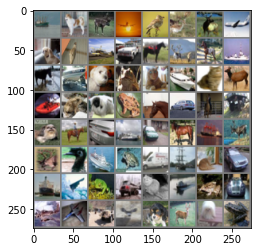

In [35]:
import matplotlib.pyplot as plt
import numpy as np
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = 0.5*img  + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define CNN

In [36]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal(m.weight.data)
        torch.nn.init.ones_(m.bias.data)
        
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=1,padding=1) 
        self.conv3 = nn.Conv2d(64, 128, 3,stride=1,padding=1) 
        self.batchn1 = nn.BatchNorm2d(32)
        self.batchn2 = nn.BatchNorm2d(64)
        self.batchn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, stride=2,padding=0) 
        self.dropout = nn.Dropout(0.5)
    
        self.fc1 = nn.Linear(128*3*3, 500)
        self.fc2 = nn.Linear(500,10)


    def forward(self, x):
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(
                            self.batchn2(self.conv2(x)))))
        x = self.pool(F.relu(self.batchn3(self.conv3(x))))
        x = self.dropout(x)
        #x = self.pool(F.relu(self.dropout(self.conv1(x))))
        #x = self.pool(F.relu(self.dropout(self.conv2(x))))
        #x = self.pool(F.relu(self.dropout(self.conv3(x))))
        #print(x.shape)
        x = x.view(x.size(0),-1)
        
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        return F.log_softmax(x,dim=1)

model=Model()
model.apply(weights_init)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if __name__ == '__main__':


Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [37]:
print("Model's state_dict:\n")
for param_tensor in model.state_dict():
    print(param_tensor, "\t ", model.state_dict()[param_tensor].size())

Model's state_dict:

conv1.weight 	  torch.Size([32, 3, 5, 5])
conv1.bias 	  torch.Size([32])
conv2.weight 	  torch.Size([64, 32, 3, 3])
conv2.bias 	  torch.Size([64])
conv3.weight 	  torch.Size([128, 64, 3, 3])
conv3.bias 	  torch.Size([128])
batchn1.weight 	  torch.Size([32])
batchn1.bias 	  torch.Size([32])
batchn1.running_mean 	  torch.Size([32])
batchn1.running_var 	  torch.Size([32])
batchn1.num_batches_tracked 	  torch.Size([])
batchn2.weight 	  torch.Size([64])
batchn2.bias 	  torch.Size([64])
batchn2.running_mean 	  torch.Size([64])
batchn2.running_var 	  torch.Size([64])
batchn2.num_batches_tracked 	  torch.Size([])
batchn3.weight 	  torch.Size([128])
batchn3.bias 	  torch.Size([128])
batchn3.running_mean 	  torch.Size([128])
batchn3.running_var 	  torch.Size([128])
batchn3.num_batches_tracked 	  torch.Size([])
fc1.weight 	  torch.Size([500, 1152])
fc1.bias 	  torch.Size([500])
fc2.weight 	  torch.Size([10, 500])
fc2.bias 	  torch.Size([10])


In [38]:
from torchsummary import summary
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           2,432
       BatchNorm2d-2           [-1, 32, 30, 30]              64
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 64, 15, 15]          18,496
       BatchNorm2d-5           [-1, 64, 15, 15]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Dropout-7             [-1, 64, 7, 7]               0
            Conv2d-8            [-1, 128, 7, 7]          73,856
       BatchNorm2d-9            [-1, 128, 7, 7]             256
        MaxPool2d-10            [-1, 128, 3, 3]               0
          Dropout-11            [-1, 128, 3, 3]               0
           Linear-12                  [-1, 500]         576,500
          Dropout-13                  [-1, 500]               0
           Linear-14                   

# Loss & Optimizer

In [39]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                milestones=[10,50,150], gamma=0.5)

In [40]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [41]:
type(validloader)

torch.utils.data.dataloader.DataLoader

# Train & Validation

In [51]:
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]

num_epochs = 2

model.to(device)
for epoch in range(num_epochs):
    print('epoch : ',epoch+1)
    model.train() 
    for i, data in enumerate(trainloader, 0):
        
        inputs = data[0].to(device)
        labels = data[1].to(device)
        print(inputs.shape,labels.shape)
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()  
    with torch.no_grad():
        running_loss = 0.0
        corrects = 0.0
        total = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs = data[0].to(device)
            inputs.shape
            labels = data[1].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            total += labels.size(0)
            corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / i
        epoch_acc = 100*corrects/total
        train_loss.append(epoch_loss)
        train_acc.append(100*corrects/total)
        print('-' * 10)
        print('train: Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))
        
        running_loss = 0.0
        corrects = 0.0
        total = 0.0
        for i, data in enumerate(validloader, 0):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            total += labels.size(0)
            corrects += (preds == labels).sum().item()  

        epoch_loss = running_loss / i
        epoch_acc = 100*corrects/total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print('valid:  Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
        print('-' * 10,'\n')

epoch :  1
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
----------
train: Loss: 1.5889 Acc: 54.3000
valid:  Los

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

In [43]:
inputs.shape

torch.Size([16, 3, 32, 32])

In [44]:
# blue for train
# darkgreen for validation
# crimson for test

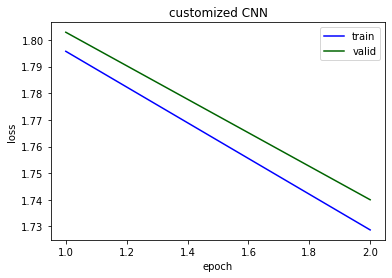

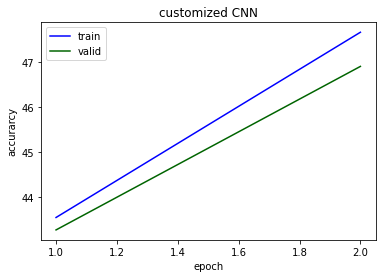

In [45]:
x_axis = range(1,num_epochs+1)

#plot loss
plt.plot(x_axis,train_loss,'blue')
plt.plot(x_axis,val_loss,'darkgreen') 
plt.legend(('train', 'valid'),loc='upper right')
plt.title('customized CNN')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#plot accuracy
plt.plot(x_axis,train_acc,'blue')
plt.plot(x_axis,val_acc,'darkgreen')
plt.legend(('train', 'valid'),loc='upper left')
plt.title('customized CNN')
plt.xlabel('epoch')
plt.ylabel('accurarcy')
plt.show()

# Train & Test

In [46]:
# train_loss=[]
# train_acc=[]
# test_loss=[]
# test_acc=[]

# num_epochs = 200

# model.to(device)
# for epoch in range(num_epochs):
#     print('epoch : ',epoch+1)
#     model.train() 
#     for i, data in enumerate(trainloader, 0):

#         inputs = data[0].to(device)
#         labels = data[1].to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#     model.eval()  
#     with torch.no_grad():
#         running_loss = 0.0
#         corrects = 0.0
#         total = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs = data[0].to(device)
#             labels = data[1].to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             total += labels.size(0)
#             corrects += (preds == labels).sum().item()

#         epoch_loss = running_loss / i
#         epoch_acc = 100*corrects/total
#         train_loss.append(epoch_loss)
#         train_acc.append(100*corrects/total)
#         print('-' * 10)
#         print('train: Loss: {:.4f} Acc: {:.4f}'.format(
#             epoch_loss, epoch_acc))
        
#         running_loss = 0.0
#         corrects = 0.0
#         total = 0.0
#         for i, data in enumerate(testloader, 0):
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
            
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             total += labels.size(0)
#             corrects += (preds == labels).sum().item()  

#         epoch_loss = running_loss / i
#         epoch_acc = 100*corrects/total
#         test_loss.append(epoch_loss)
#         test_acc.append(epoch_acc)

#         print('test:  Loss: {:.4f} Acc: {:.4f}'.format(
#         epoch_loss, epoch_acc))
#         print('-' * 10,'\n')

In [47]:
# x_axis = range(1,num_epochs+1)

# #plot loss
# plt.plot(x_axis,train_loss,'blue')
# plt.plot(x_axis,test_loss,'crimson') 
# plt.legend(('train', 'test'),loc='upper right')
# plt.title('customized CNN')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

# #plot accuracy
# plt.plot(x_axis,train_acc,'blue')
# plt.plot(x_axis,test_acc,'crimson')
# plt.legend(('train', 'test'),loc='upper left')
# plt.title('customized CNN')
# plt.xlabel('epoch')
# plt.ylabel('accurarcy')
# plt.show()